**<font size=5>Visualizing and Understanding K-Means Clusters</font>**

The purpose of this notebook is to analyze the 1995 U.S. News and World Report college statistics dataset using K-means clustering. In this notebook I generate the clusters and then look at a couple different ways of visualizing and understanding the cluster output. Let's begin with the usual: import statements, data load, quick look at the dataset.

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.cluster import KMeans
#import sklearn.cluster.hierarchical as hclust
from sklearn import preprocessing
import seaborn as sns

In [2]:
df = pd.read_csv('../input/College.csv')

In [3]:
print(df.shape)
df.head()

(777, 19)


Unnamed: 0 Private    ...      Expend  Grad.Rate
0  Abilene Christian University     Yes    ...        7041         60
1            Adelphi University     Yes    ...       10527         56
2                Adrian College     Yes    ...        8735         54
3           Agnes Scott College     Yes    ...       19016         59
4     Alaska Pacific University     Yes    ...       10922         15

[5 rows x 19 columns]

The Kaggle [site](https://www.kaggle.com/flyingwombat/us-news-and-world-reports-college-data/home) has the descriptions of each data column, copied here for easy reference:
* "Private A factor with levels No and Yes indicating private or public university
* Apps Number of applications received
* Accept Number of applications accepted
* Enroll Number of new students enrolled
* Top10perc Pct. new students from top 10% of H.S. class
* Top25perc Pct. new students from top 25% of H.S. class
* F.Undergrad Number of fulltime undergraduates
* P.Undergrad Number of parttime undergraduates
* Outstate Out-of-state tuition
* Room.Board Room and board costs
* Books Estimated book costs
* Personal Estimated personal spending
* PhD Pct. of faculty with Ph.D.’s
* Terminal Pct. of faculty with terminal degree
* S.F.Ratio Student/faculty ratio
* perc.alumni Pct. alumni who donate
* Expend Instructional expenditure per student
* Grad.Rate Graduation rate"

**<font size=5>Features</font>**

Note that there's a categorical variable in our data - 'Private'. Categorical variables are tricky for clustering. You can't cluster off a categorical variable, so you'd have to do some kind of mapping to it. This can be intuitive for ordinal data, but for non-ordinal categorical variables, assigning numerical values can impact the clusters in ways not meaningful about the underlying data. 'Private' is a binary variable, yes or no, but mapping 0 or 1 would have outsized impact on clustering, since each point would be all the way at the min or the max of this variable while other variables will be continuous. For now, we will disregard this variable.

In [4]:
#exclude the categorical column and the college names
features = df.drop(['Private', 'Unnamed: 0'],axis=1)

There are three columns - 'Apps', 'Accept', and 'Enroll' - that can be collapsed into percentages if we choose. The absolute numbers could be informative - maybe a high number of acceptances means we are looking at a very large school, for example. However, if two schools have an "Accept" of, say, 1000, this could mean very different things if "Apps" was 10,000 (10% acceptance rate) versus 2,000 (50%). So let's create a % accepted column (Accept / Apps) and % enroll column (Enroll / Accept).

In [5]:
features['Acceptperc'] = features['Accept'] / features['Apps']
features['Enrollperc'] = features['Enroll'] / features['Accept']

In [6]:
features.describe()

Apps        Accept     ...      Acceptperc  Enrollperc
count    777.000000    777.000000     ...      777.000000  777.000000
mean    3001.638353   2018.804376     ...        0.746928    0.412015
std     3870.201484   2451.113971     ...        0.147104    0.133989
min       81.000000     72.000000     ...        0.154486    0.099754
25%      776.000000    604.000000     ...        0.675647    0.317204
50%     1558.000000   1110.000000     ...        0.778750    0.387419
75%     3624.000000   2424.000000     ...        0.848522    0.485674
max    48094.000000  26330.000000     ...        1.000000    1.000000

[8 rows x 19 columns]

**Normalization**

Note that the different categories have different ranges. If we don't normalize them, then columns with wider ranges will have disproportionate contributions to cluster separations.

In [7]:
scaler = preprocessing.MinMaxScaler()
features_normal = scaler.fit_transform(features)

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


In [8]:
pd.DataFrame(features_normal).describe()

0           1      ...              17          18
count  777.000000  777.000000     ...      777.000000  777.000000
mean     0.060830    0.074141     ...        0.700688    0.346862
std      0.080607    0.093347     ...        0.173982    0.148836
min      0.000000    0.000000     ...        0.000000    0.000000
25%      0.014475    0.020260     ...        0.616384    0.241545
50%      0.030763    0.039531     ...        0.738325    0.319540
75%      0.073793    0.089573     ...        0.820845    0.428683
max      1.000000    1.000000     ...        1.000000    1.000000

[8 rows x 19 columns]

Now all of our variables are scaled to be distributed between 0 and 1.

**<font size=5>K-Means Clustering</font>**

How many clusters should we group these colleges into? We can use the elbow method to decide. Plot the sum of squared distances of the data points from their cluster's center for increasing numbers of clusters and see if you can find a clear cluster number where the decrease in distortion starts to level off. A quick tutorial that worked me through this part of the code is [here](https://pythonprogramminglanguage.com/kmeans-elbow-method/).

In [9]:
inertia = []
K = range(1,10)
for k in K:
    kmeanModel = KMeans(n_clusters=k).fit(features_normal)
    kmeanModel.fit(features_normal)
    inertia.append(kmeanModel.inertia_)

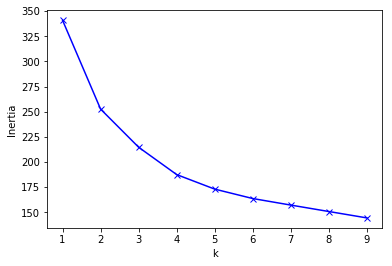

In [10]:
# Plot the elbow
plt.plot(K, inertia, 'bx-')
plt.xlabel('k')
plt.ylabel('Inertia')
plt.show()

The elbow method is subjective but it looks like 4 might be the pivot point we're looking for. Let's try 4 clusters.

In [11]:
kmeans = KMeans(n_clusters=4).fit(features_normal)

In [12]:
labels = pd.DataFrame(kmeans.labels_) #This is where the label output of the KMeans we just ran lives. Make it a dataframe so we can concatenate back to the original data
labeledColleges = pd.concat((features,labels),axis=1)
labeledColleges = labeledColleges.rename({0:'labels'},axis=1)

In [13]:
labeledColleges.head()

Apps  Accept  Enroll   ...    Acceptperc  Enrollperc  labels
0  1660    1232     721   ...      0.742169    0.585227       3
1  2186    1924     512   ...      0.880146    0.266112       3
2  1428    1097     336   ...      0.768207    0.306290       3
3   417     349     137   ...      0.836930    0.392550       1
4   193     146      55   ...      0.756477    0.376712       3

[5 rows x 20 columns]

**<font size=5>Visualization</font>**
    
*(Nota bene: I'm plotting the original data in these visualizations, not their normalized scaled versions. We clustered based on the normalized data but I wanted to see how that translates to the colleges' actual stats)*

The original dataset had 18 features. We dropped one and added two more, so we clustered on 19. We have 5 clusters of points in 19-dimensional space, which is hard to visualize. If we only had two attributes, we could look at how the clusters separate like this:

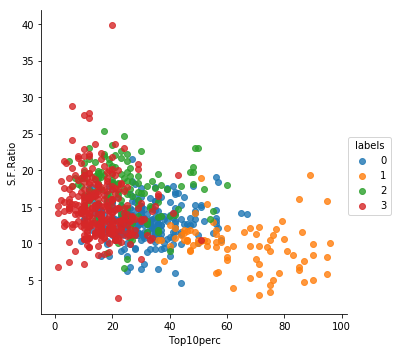

In [14]:
sns.lmplot(x='Top10perc',y='S.F.Ratio',data=labeledColleges,hue='labels',fit_reg=False)

Here we plotted the Top 10 Percent column (" Pct. new students from top 10% of H.S. class") versus the Student/Faculty ratio column and color-coded each data point by the cluster to which it was assigned. You can start to get the sense of which clusters have lower student/faculty ratios or are more selective in the students they accept. However, we can't see 4 clearly distinct clusters just by plotting these two variables; we have 17 other variables contributing to the separation that we have to consider to get the full picture. We can't plot all 19 variables together on one plot like the one above. We could plot every variable against every other variable:

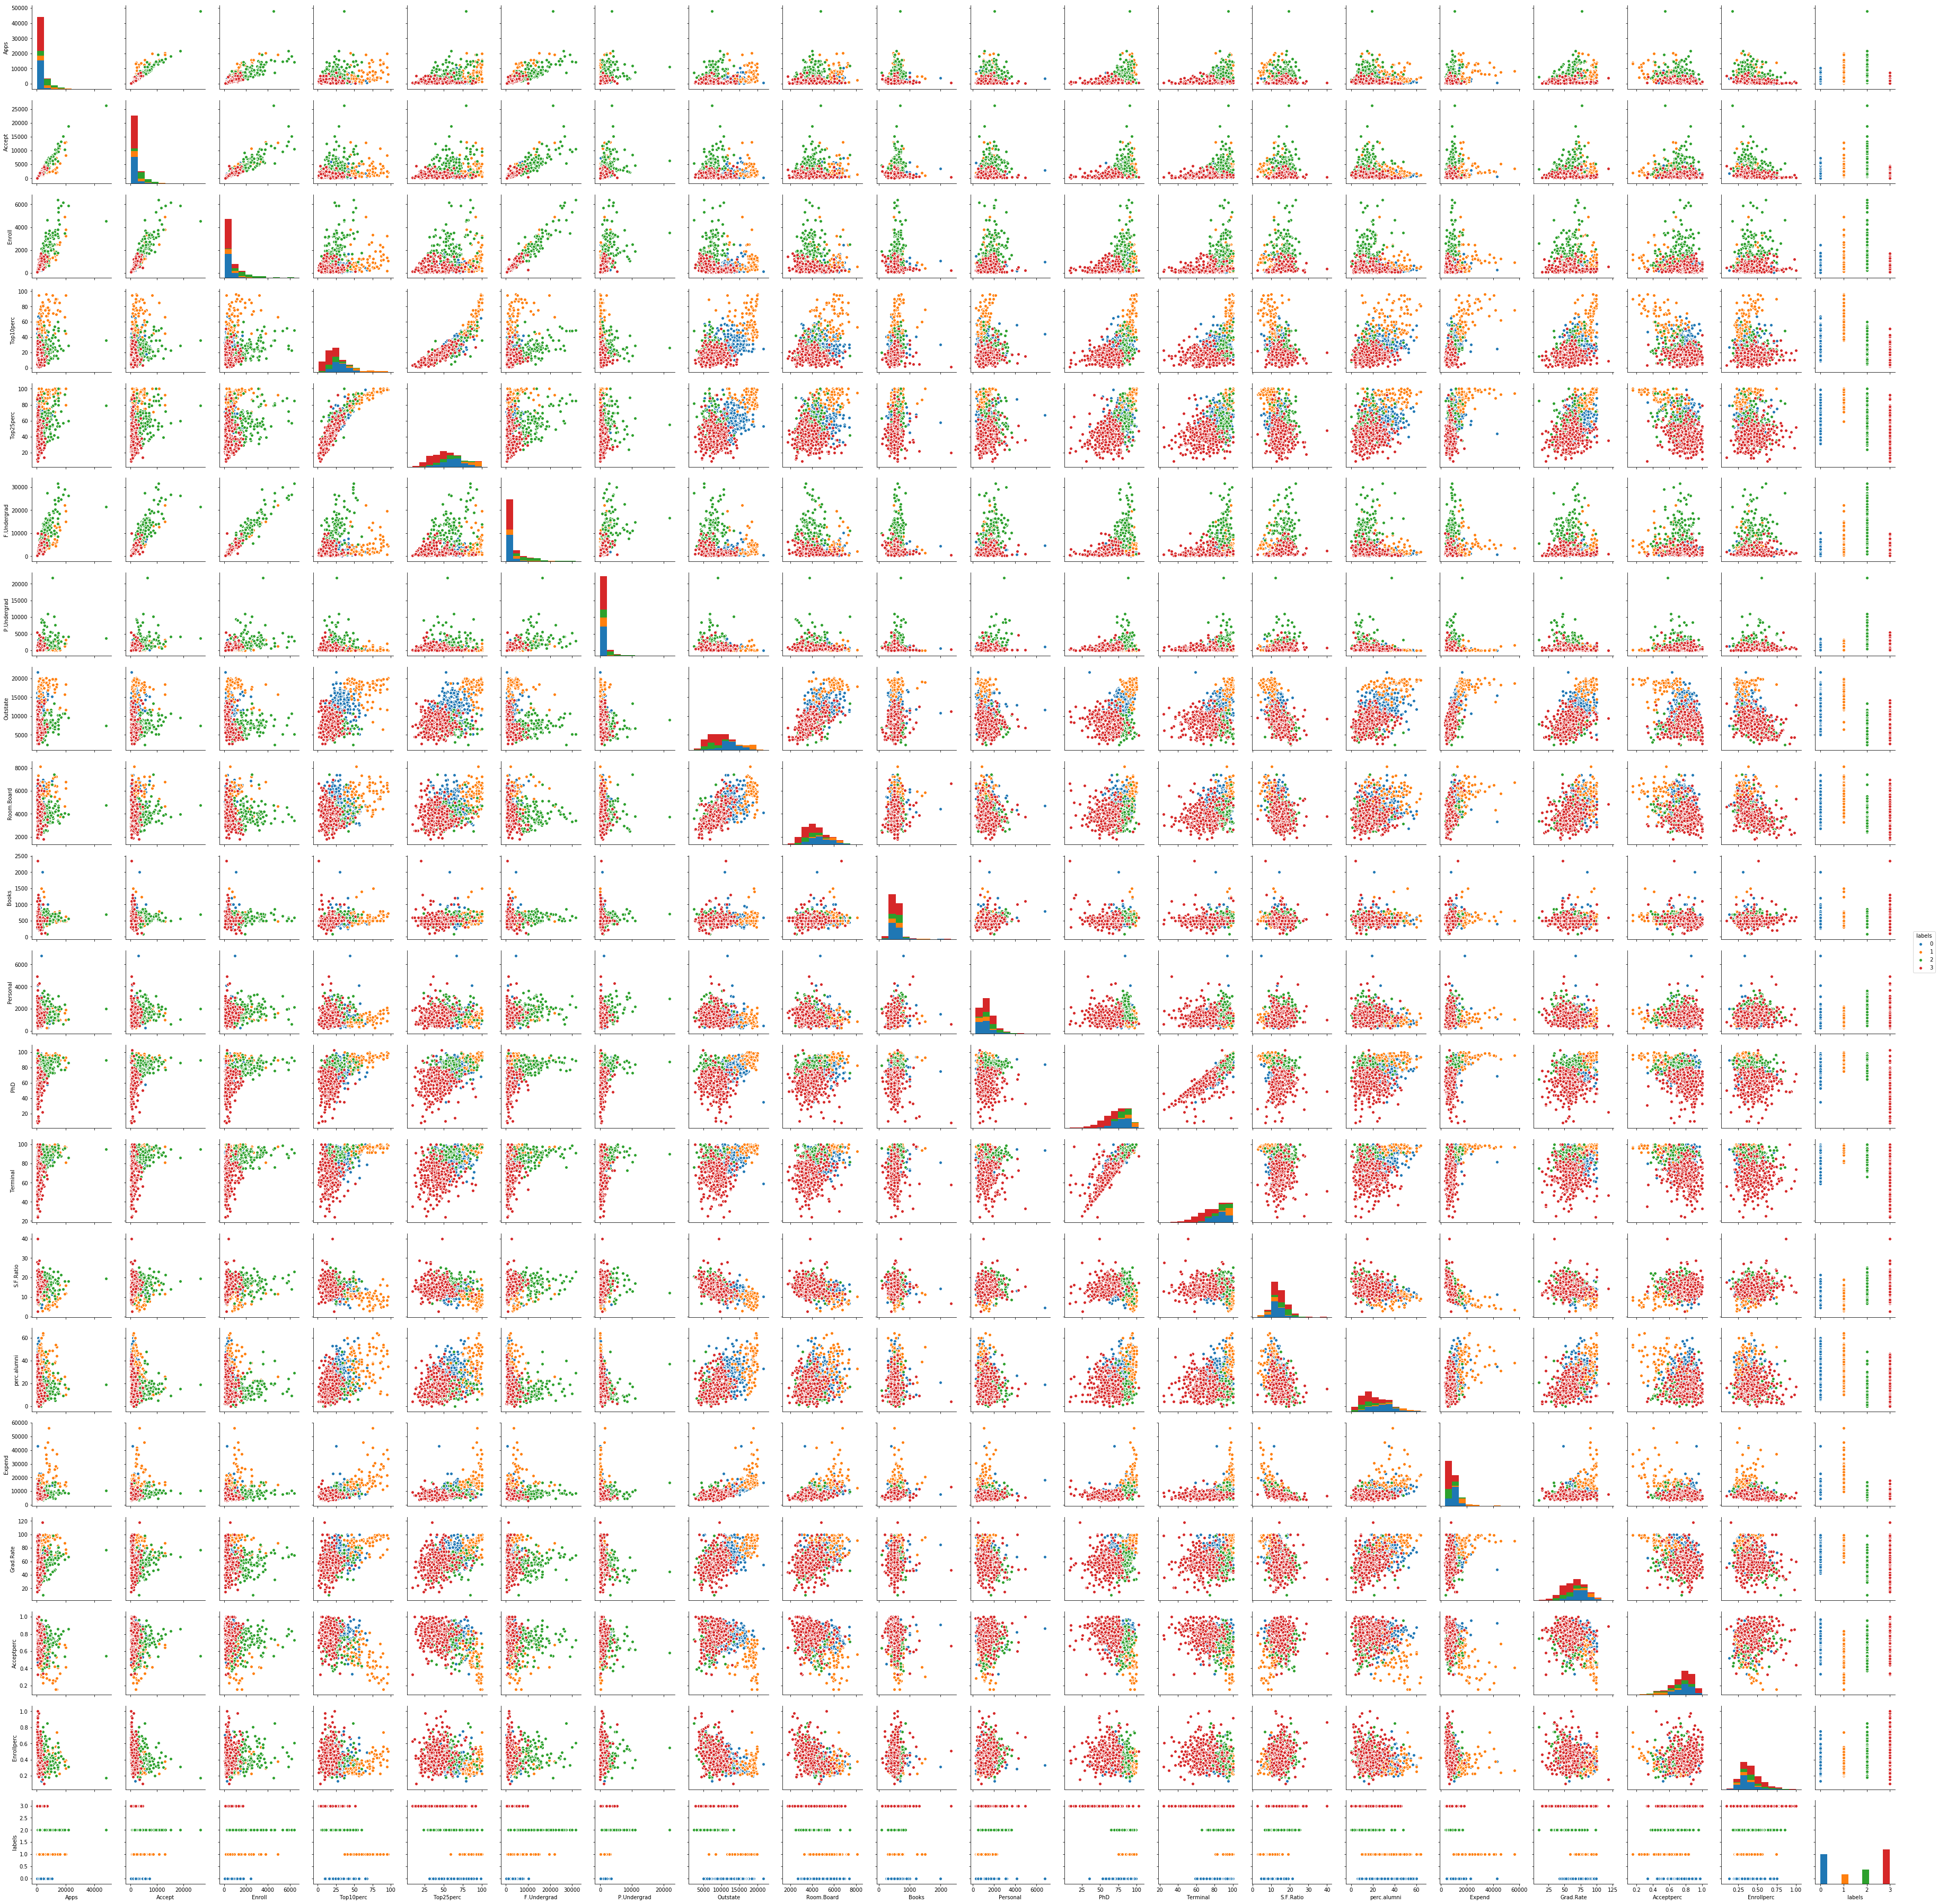

In [15]:
sns.pairplot(labeledColleges,hue='labels')

This is nice for scanning by eye and seeing what variables give you nice separation and getting a sense for what happened in the clusters, but there's a lot going on and it's hard to get a quick answer to questions like "what features tend to define cluster 0? How about cluster 3?" Let's try visualizing each variable separately using strip plots and swarm plots.

In [16]:
labeledColleges['Constant'] = "Data" #This is just to add something constant for the strip/swarm plots' X axis. Can be anything you want it to be.

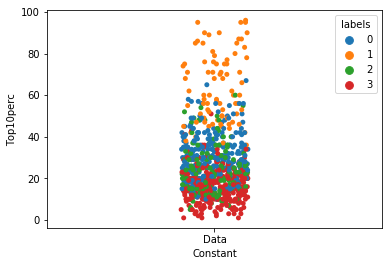

In [17]:
sns.stripplot(x=labeledColleges['Constant'],y=labeledColleges['Top10perc'],hue=labeledColleges['labels'],jitter=True)

This is a strip plot. Seaborn plots one data point for each row and we've color coded the points by the cluster to which they were assigned. Adding jitter fans out the points horizontally. In a strip plot, the points can overlap. In a swarm plot (below), the points cannot overlap.

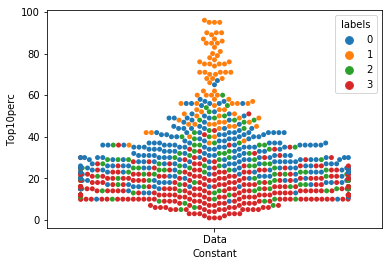

In [18]:
sns.swarmplot(x=labeledColleges['Constant'],y=labeledColleges['Top10perc'],hue=labeledColleges['labels'])

Let's look at all the features. 

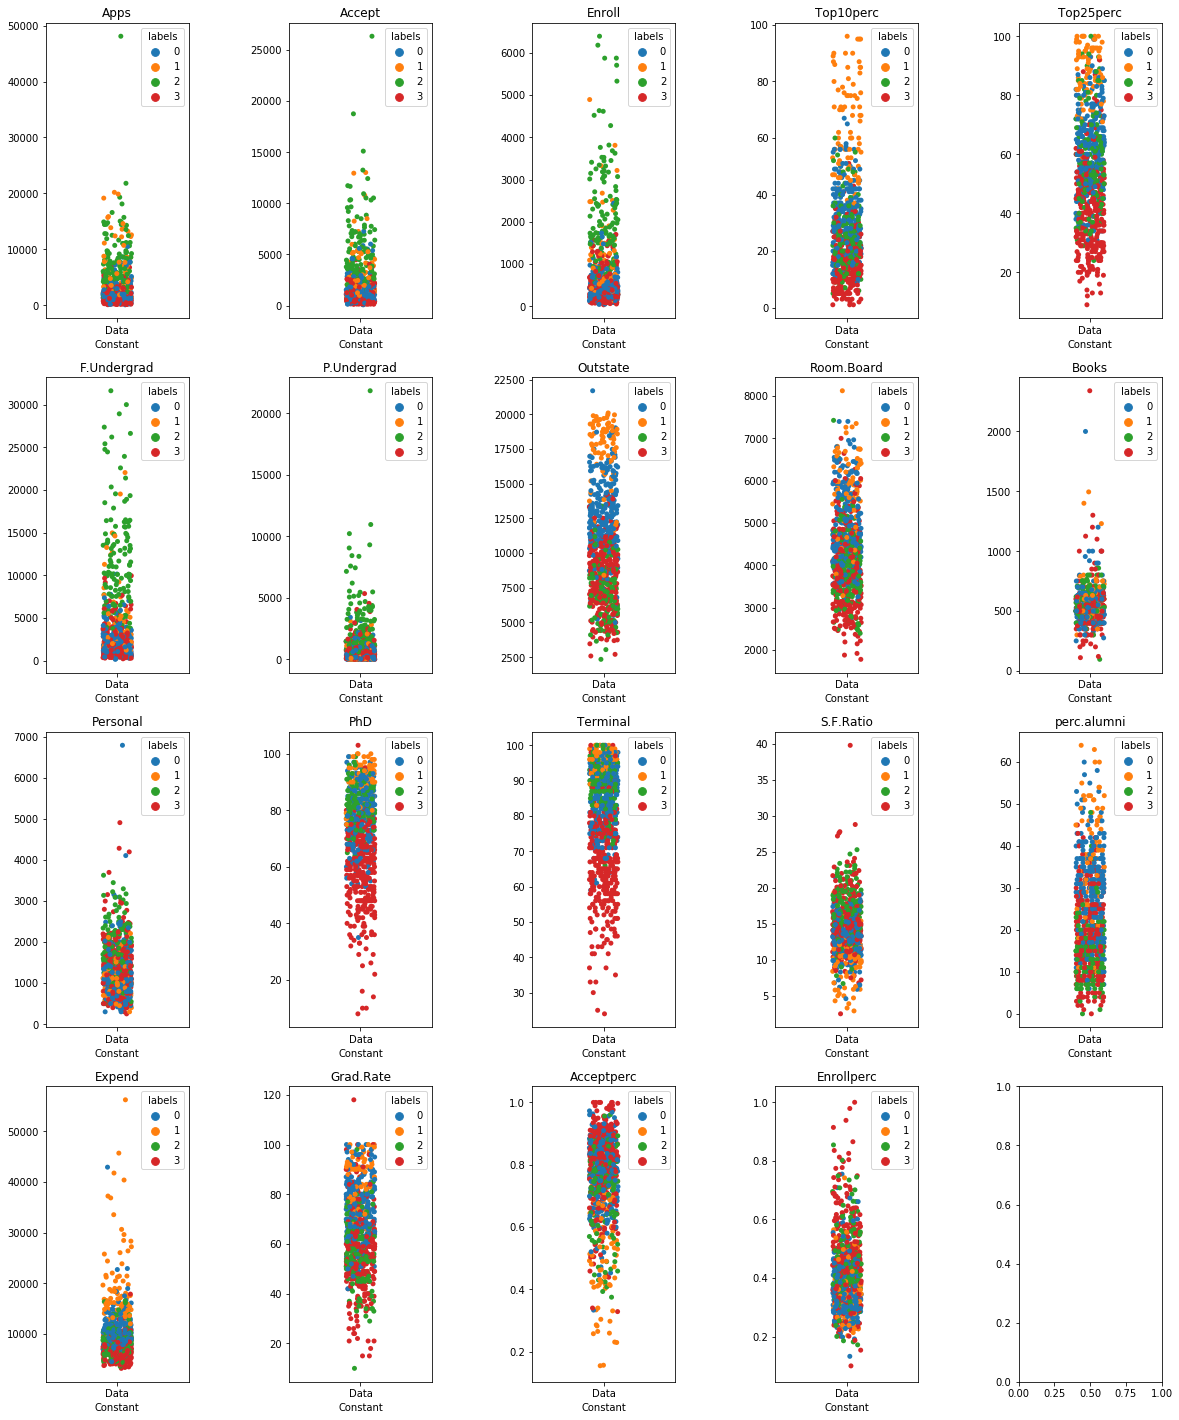

In [19]:
f, axes = plt.subplots(4, 5, figsize=(20, 25), sharex=False) #create a 4x5 grid of empty figures where we will plot our feature plots. We will have a couple empty ones.
f.subplots_adjust(hspace=0.2, wspace=0.7) #Scooch em apart, give em some room
#In this for loop, I step through every column that I want to plot. This is a 4x5 grid, so I split this up by rows of 5 in the else if statements
for i in range(0,len(list(labeledColleges))-2): #minus two because I don't want to plot labels or constant
    col = labeledColleges.columns[i]
    if i < 5:
        ax = sns.stripplot(x=labeledColleges['Constant'],y=labeledColleges[col].values,hue=labeledColleges['labels'],jitter=True,ax=axes[0,(i)])
        ax.set_title(col)
    elif i >= 5 and i<10:
        ax = sns.stripplot(x=labeledColleges['Constant'],y=labeledColleges[col].values,hue=labeledColleges['labels'],jitter=True,ax=axes[1,(i-5)]) #so if i=6 it is row 1 column 1
        ax.set_title(col)
    elif i >= 10 and i<15:
        ax = sns.stripplot(x=labeledColleges['Constant'],y=labeledColleges[col].values,hue=labeledColleges['labels'],jitter=True,ax=axes[2,(i-10)])
        ax.set_title(col)
    elif i >= 15:
        ax = sns.stripplot(x=labeledColleges['Constant'],y=labeledColleges[col].values,hue=labeledColleges['labels'],jitter=True,ax=axes[3,(i-15)])
        ax.set_title(col)

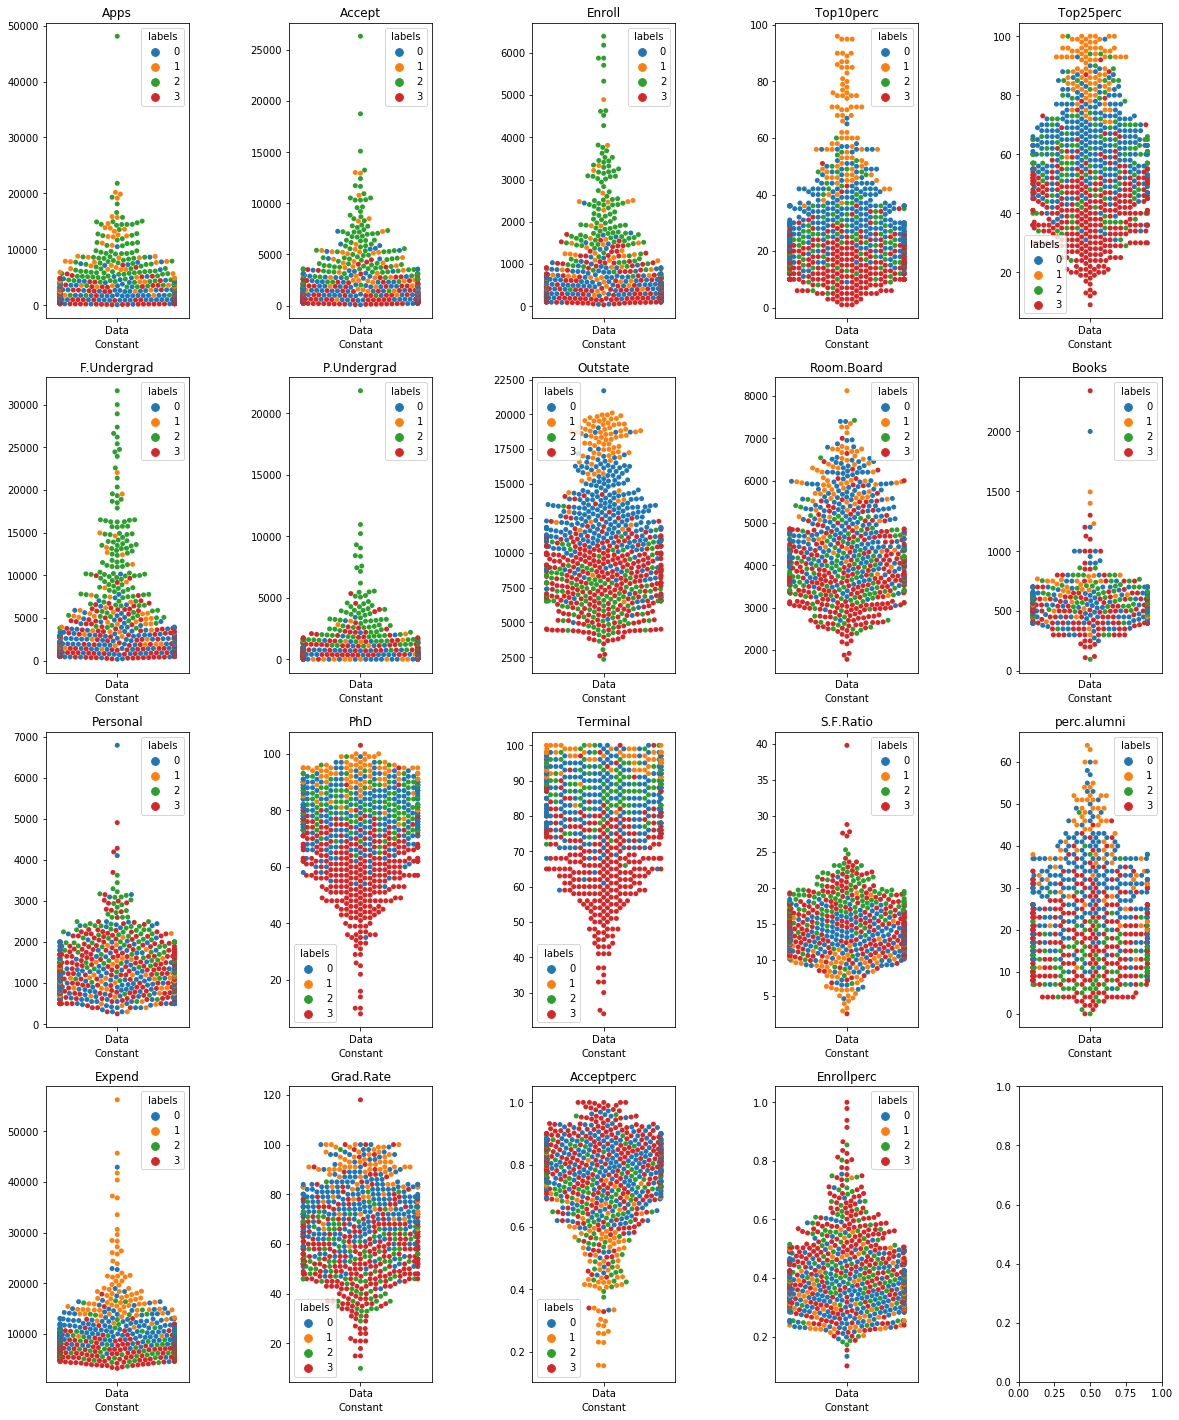

In [20]:
f, axes = plt.subplots(4, 5, figsize=(20, 25), sharex=False) 
f.subplots_adjust(hspace=0.2, wspace=0.7)
for i in range(0,len(list(labeledColleges))-2):
    col = labeledColleges.columns[i]
    if i < 5:
        ax = sns.swarmplot(x=labeledColleges['Constant'],y=labeledColleges[col].values,hue=labeledColleges['labels'],ax=axes[0,(i)])
        ax.set_title(col)
    elif i >= 5 and i<10:
        ax = sns.swarmplot(x=labeledColleges['Constant'],y=labeledColleges[col].values,hue=labeledColleges['labels'],ax=axes[1,(i-5)])
        ax.set_title(col)
    elif i >= 10 and i<15:
        ax = sns.swarmplot(x=labeledColleges['Constant'],y=labeledColleges[col].values,hue=labeledColleges['labels'],ax=axes[2,(i-10)])
        ax.set_title(col)
    elif i >= 15:
        ax = sns.swarmplot(x=labeledColleges['Constant'],y=labeledColleges[col].values,hue=labeledColleges['labels'],ax=axes[3,(i-15)])
        ax.set_title(col)

So, if you were looking for a college in 1995, you could scan these clusters and get a sense for which cluster might offer what you're looking for. Do you want a more exclusive school? Look for clusters that plot higher in Top10perc and Top25perc. But cluster 1 schools are also more expensive, with higher out-of-state tuition and room and board costs. Maybe you're looking for a big school - look for clusters with higher numbers of full-time undergrad students. When you find a cluster you like, you can see the college list here:

In [21]:
colleges = df['Unnamed: 0']
colleges = pd.concat((colleges,labels),axis=1)
colleges = colleges.rename({'Unnamed: 0':'College',0:'Cluster'},axis=1)
sortcolleges = colleges.sort_values(['Cluster'])
pd.set_option('display.max_rows', 1000)
sortcolleges

College  Cluster
776                   York College of Pennsylvania        0
308                         Lebanon Valley College        0
307                               Le Moyne College        0
306                            Lawrence University        0
643                University of Missouri at Rolla        0
301                            Lake Forest College        0
298                            La Salle University        0
296                                   Knox College        0
648                      University of New England        0
294                                 King's College        0
293                                  Keuka College        0
287                                Juniata College        0
283                        John Carroll University        0
278                                 Ithaca College        0
276                                   Iona College        0
542                                Spelman College        0
268               Illinois Institute of Technology        0
267                               Illinois College        0
310                           Lenoir-Rhyne College        0
313                        Lewis and Clark College        0
639              University of Minnesota at Morris        0
636                            University of Miami        0
618                       University of Evansville        0
353                               Marywood College        0
351                              Maryville College        0
348                    Marymount College Tarrytown        0
347                        Mary Washington College        0
346                           Mary Baldwin College        0
344                           Marquette University        0
343                                 Marist College        0
266                   Illinois Benedictine College        0
342                               Marietta College        0
338                              Manhattan College        0
331                               Lycoming College        0
330                                 Luther College        0
329                      Loyola University Chicago        0
328                              Loyola University        0
327                    Loyola Marymount University        0
326                                 Loyola College        0
318                               Linfield College        0
339                         Manhattanville College        0
617                          University of Dubuque        0
261                               Houghton College        0
259                                   Hood College        0
213                              Furman University        0
681                    University of St. Thomas MN        0
682                    University of St. Thomas TX        0
209                               Franklin College        0
205                             Fordham University        0
200                Florida Institute of Technology        0
688                      University of the Pacific        0
690                            University of Tulsa        0
196                           Fairfield University        0
194                                 Eureka College        0
193                                Erskine College        0
692                          University of Vermont        0
190                          Emory & Henry College        0
187                                   Elms College        0
186                                 Elmira College        0
185                          Elizabethtown College        0
184                                 Eckerd College        0
227                             Gonzaga University        0
228                                 Gordon College        0
673                         University of Scranton        0
230                                Goucher College        0
258                                Hollins College        0
257                    